Import Packages

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_dilation, binary_closing, binary_erosion, binary_opening


Step 0

Select map.

In [2]:
original_map = "Step_0/1619.tif"

Step 1

Detect black pixels and create a binary image.

input_file is the georeferenced tif you're interestsed in from the Step_0 folder.

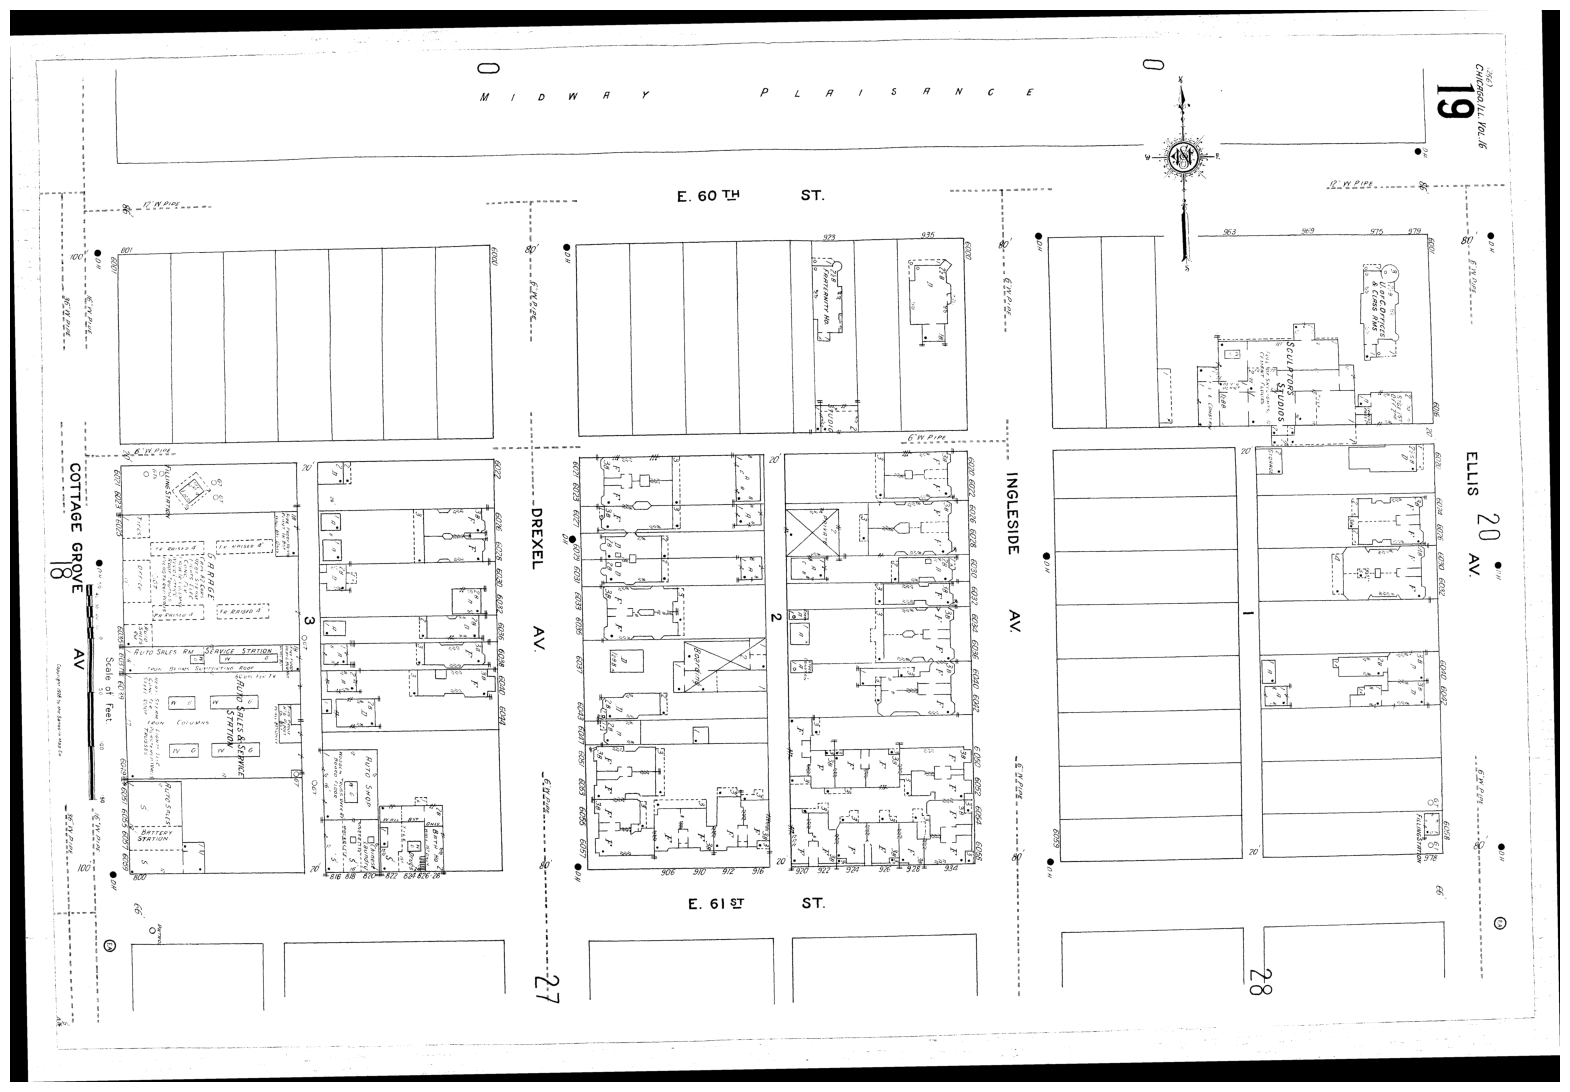

(4, 5706, 8248)


In [3]:
# Open the input GeoTIFF file
output_file = "Step_1/Step_1.tif"

# Define the threshold for black pixels
black_threshold = 70  # Adjust the threshold as needed for black pixel detection

# Define the minimum area for regions to be preserved (optional, can be removed if not needed)
min_region_area = 1

with rasterio.open(original_map) as src:
    # Read the image data
    img_data: np.ndarray = src.read()
    
    # Convert to 8-bit unsigned integer (assuming input is in some other format)
    img_data = img_data.astype('uint8')
    
    # Check the band count and shape
    num_bands, height, width = img_data.shape
    
    # Define black pixels (low RGB values for black)
    black_pixels = (img_data[0] <= black_threshold) & (img_data[1] <= black_threshold) & (img_data[2] <= black_threshold)
    
    # Create a binary mask where black pixels are True, and everything else is False
    foreground_mask = black_pixels
    
    # Create the output image: set black pixels to black (0), everything else to white (255)
    binary_image = np.ones((height, width), dtype=np.uint8) * 255  # Initialize as all white
    binary_image[foreground_mask] = 0  # Set black pixels to 0 (black)

    # Create a new GeoTIFF file for the binary image
    profile = src.profile
    profile.update(count=1, dtype='uint8')  # Single-band, 8-bit unsigned integer
    
    with rasterio.open(output_file, 'w', **profile) as dst:
        # Write the binary image data to the output file
        dst.write(binary_image, 1)

# Open the output binary image using Matplotlib for preview
plt.figure(figsize=(20, 18))  # Adjust the width and height as needed
plt.imshow(binary_image, cmap='gray')  # Display the binary image in grayscale (black and white)
plt.axis('off')
plt.show()

print(img_data.shape)

Step 1.5 

Adjustable dilation to make sure lines are solid and don't get filtered out.

Key here is to ensure that the lines are solid, but that the letters / words don't bind to the building outlines (because if they do, they won't get filtered out later).

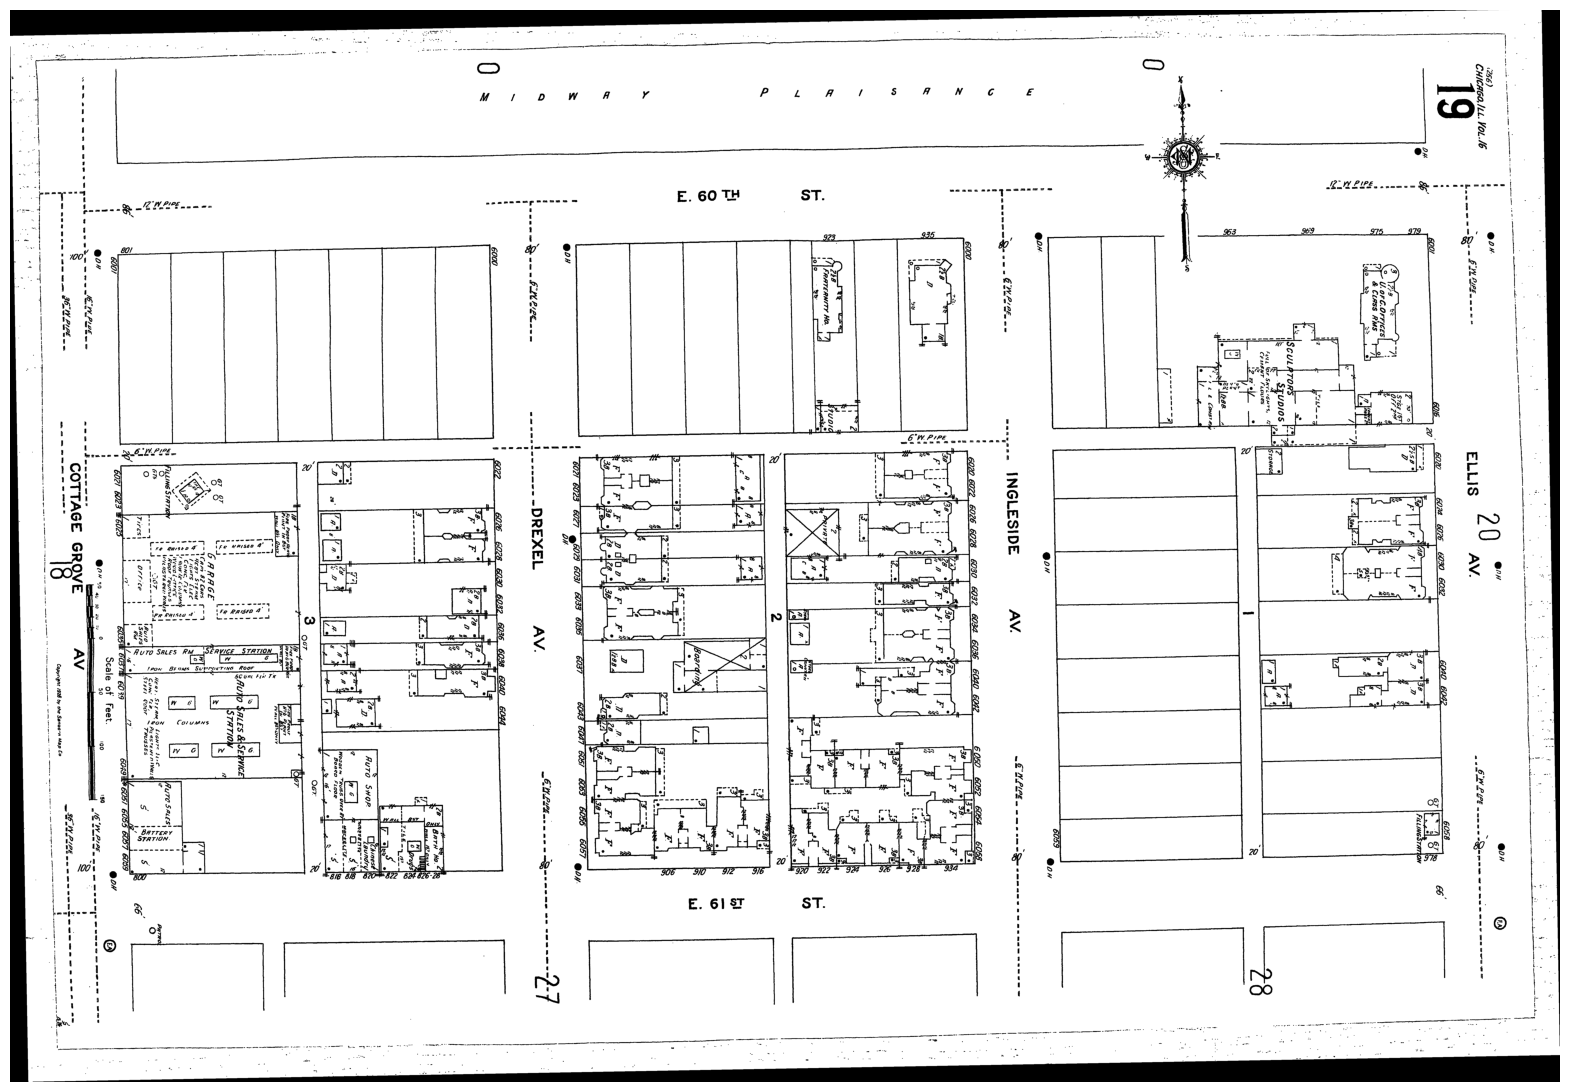

In [4]:
# Input and output file paths
input_file = "Step_1/Step_1.tif"
output_file = "Step_1.5/Step_1.5.tif"

# Threshold for foreground (black pixels)
foreground_threshold = 35

# Dilation intensity modifier (larger value = more dilation)
dilation_modifier = 3  # Adjust this value to control dilation intensity

# Open the input GeoTIFF file
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Threshold to create a foreground mask (black pixels)
    foreground_mask = img_data <= foreground_threshold  # 0=black, foreground

    # Create a structuring element for dilation
    dilation_element = np.ones((dilation_modifier, dilation_modifier), dtype=bool)

    # Apply binary dilation to the foreground mask
    dilation_mask = binary_dilation(foreground_mask, structure=dilation_element)

    # Create a new image with the dilated regions
    dilated_img = np.full_like(img_data, 255, dtype='uint8')  # Initialize as white
    dilated_img[dilation_mask] = 0  # Set dilated regions to black

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(dilated_img, 1)  # Write to the first band

# Display the processed image
plt.figure(figsize=(20, 18))
plt.imshow(dilated_img, cmap='gray')
plt.axis('off')
plt.show()

Step 2

Treat clumps of pixels as polygons with an area and filter out those below a certain threshold (min_area_threshold) to clean up noise.

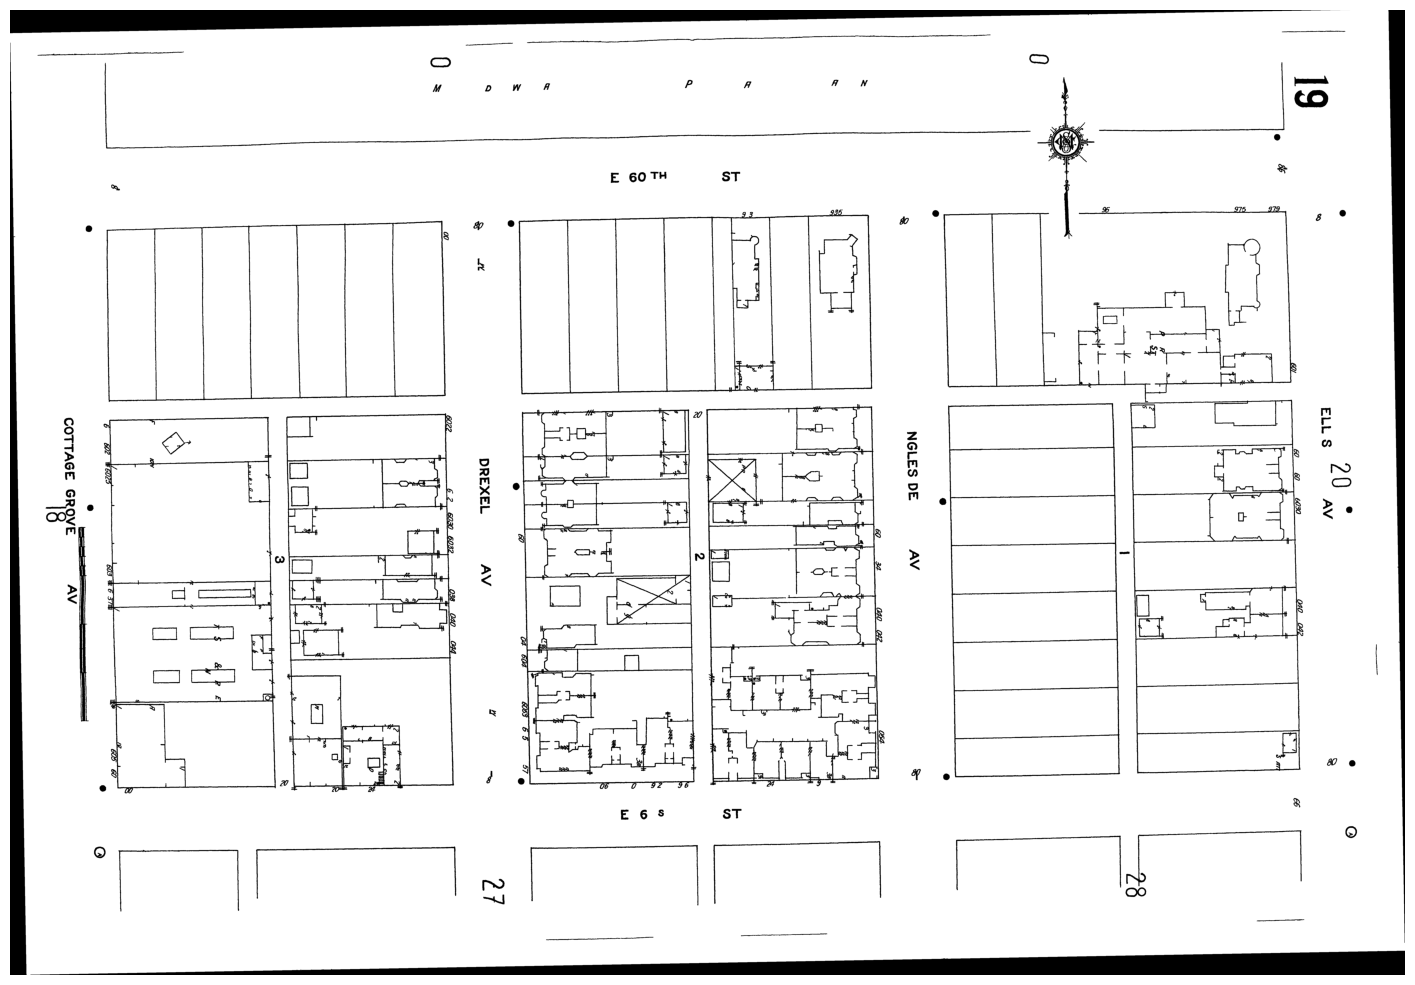

In [5]:
# Input and output file paths
input_file = "Step_1.5/Step_1.5.tif"  # Use dilated image from the first code as input
output_file = "Step_2/Step_2.tif"

# Threshold for foreground (black pixels)
foreground_threshold = 20

# Minimum area threshold for connected components (in pixels squared)
min_area_threshold = 700

# Open the input GeoTIFF file (dilated output)
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Threshold to create a foreground mask (black pixels)
    foreground_mask = img_data <= foreground_threshold  # 0=black, foreground

    # Label connected components (clusters of black pixels)
    labels, num_features = label(foreground_mask)  # Connected components labeling

    # Compute the size of each connected component (use bincount for efficiency)
    component_sizes = np.bincount(labels.ravel())  # Count sizes of each component
    component_sizes[0] = 0  # Ignore the background (label 0)

    # Filter out small components (use boolean indexing)
    valid_labels = np.where(component_sizes >= min_area_threshold)[0]  # Labels that meet size threshold

    # Create a mask for the valid components
    filtered_mask = np.isin(labels, valid_labels)  # True for valid components, False otherwise

    # Create a new image with the filtered mask
    filtered_img = np.full_like(img_data, 255, dtype='uint8')  # Initialize as white (255)
    filtered_img[filtered_mask] = img_data[filtered_mask]  # Keep the original black pixels in valid components

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(filtered_img, 1)  # Write to the first band

    # Display the processed image
    plt.figure(figsize=(18, 16))
    plt.imshow(filtered_img, cmap='gray')
    plt.axis('off')
    plt.show()

Step 3

Dilation to make lines more obvious for polygonization.

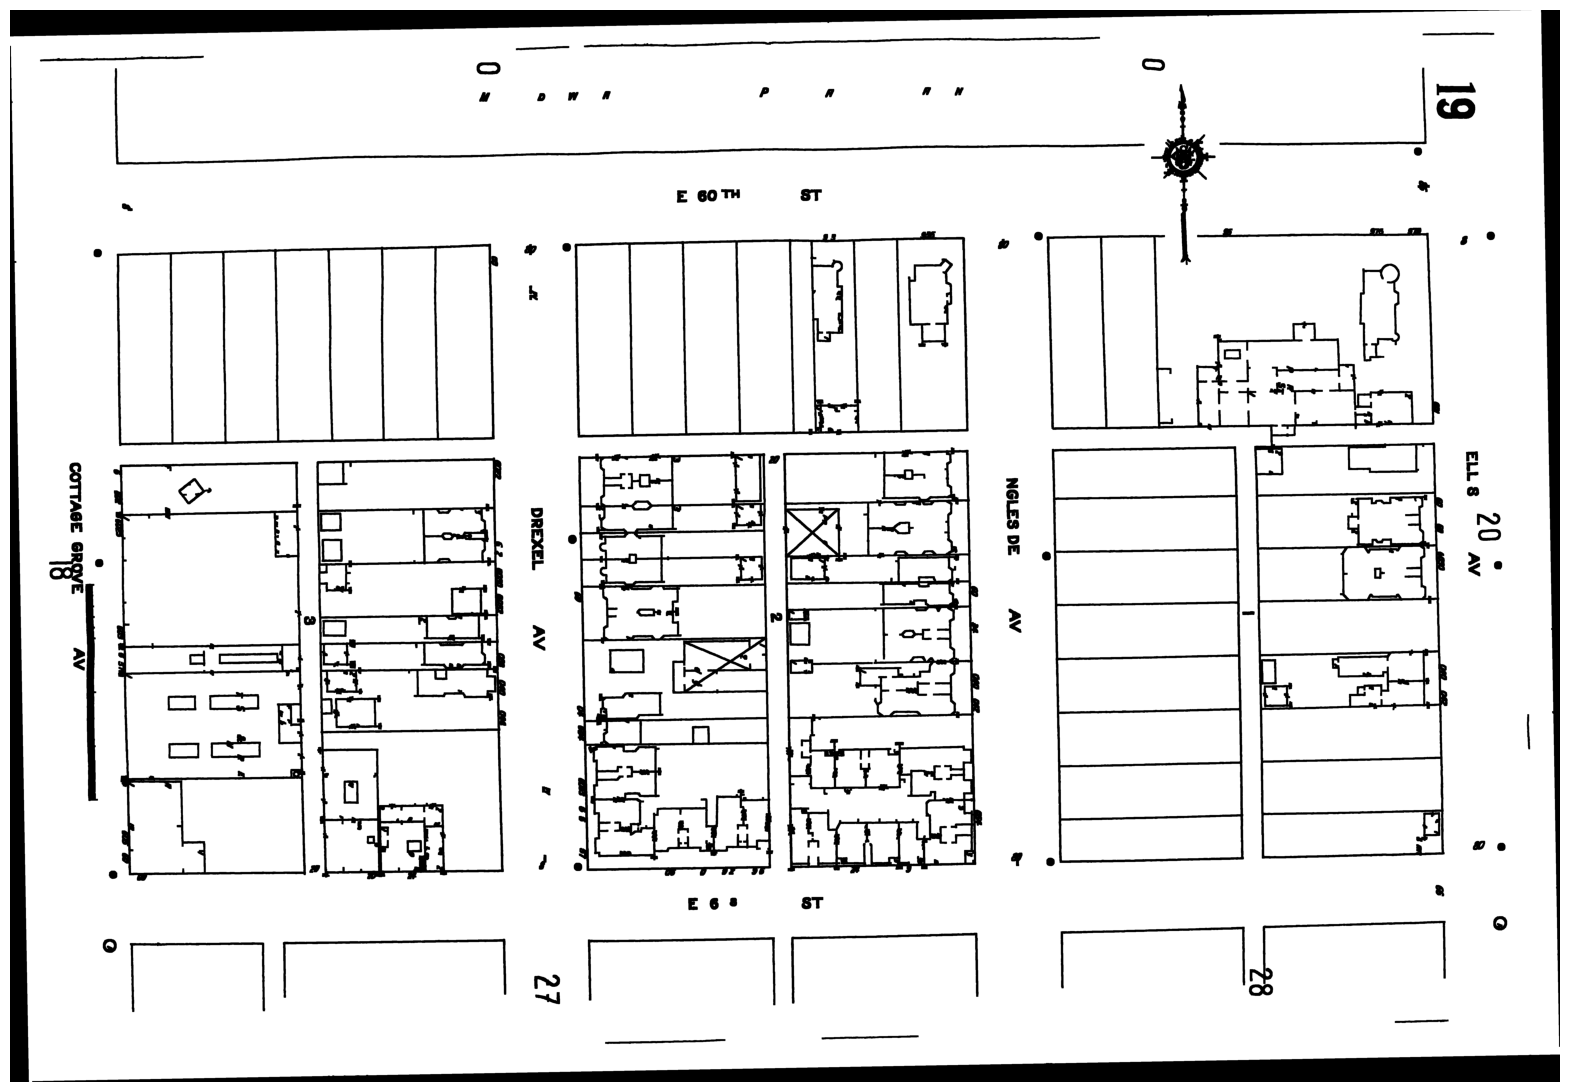

In [6]:
# Input and output file paths
input_file = "Step_2/Step_2.tif"
output_file = "Step_3/Step_3.tif"

# Threshold for foreground (black pixels)
foreground_threshold = 35

# Dilation intensity modifier (larger value = more dilation)
dilation_modifier = 7  # Adjust this value to control dilation intensity

# Open the input GeoTIFF file
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Threshold to create a foreground mask (black pixels)
    foreground_mask = img_data <= foreground_threshold  # 0=black, foreground

    # Create a structuring element for dilation
    dilation_element = np.ones((dilation_modifier, dilation_modifier), dtype=bool)

    # Apply binary dilation to the foreground mask
    dilation_mask = binary_dilation(foreground_mask, structure=dilation_element)

    # Create a new image with the dilated regions
    dilated_img = np.full_like(img_data, 255, dtype='uint8')  # Initialize as white
    dilated_img[dilation_mask] = 0  # Set dilated regions to black

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(dilated_img, 1)  # Write to the first band

# Display the processed image
plt.figure(figsize=(20, 18))
plt.imshow(dilated_img, cmap='gray')
plt.axis('off')
plt.show()

Step 4

Closing to smooth lines.

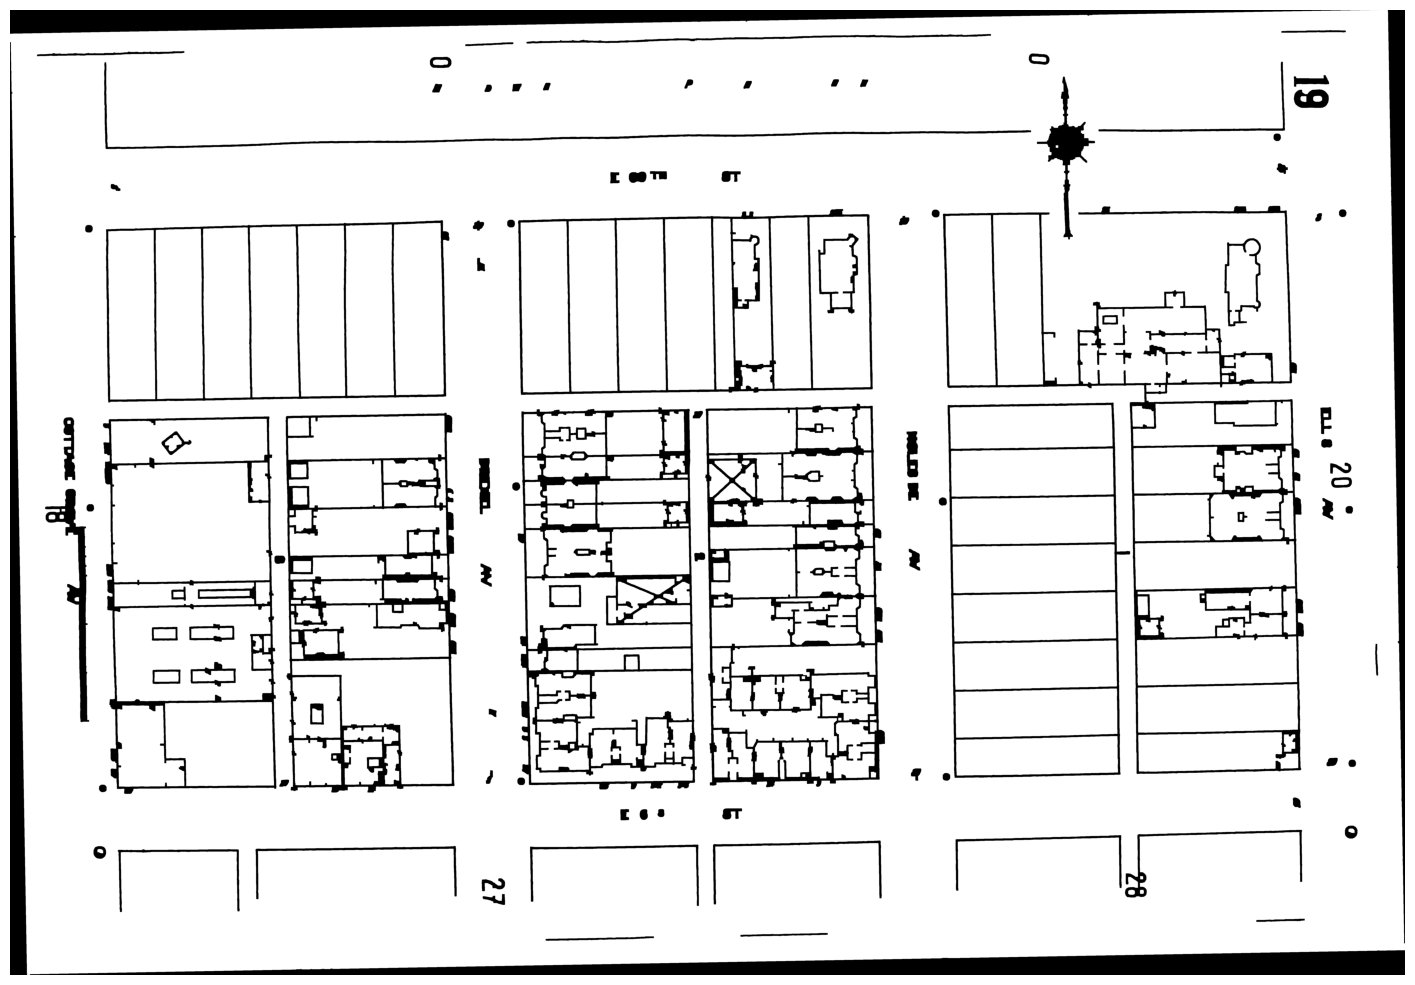

In [7]:
# Input and output file paths
input_file = "Step_3/Step_3.tif"
output_file = "Step_4/Step_4.tif"

# Thresholds for dashed lines (adjust these values as needed)
line_threshold = 35  # Pixel intensity threshold for dashed lines

# Structuring element sizes
closing_size = 15  # Size for closing gaps in dashed lines

# Open the input GeoTIFF file
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Step 1: Isolate dashed lines
    dashed_mask = img_data <= line_threshold  # True for dashed-line pixels

    # Step 2: Apply morphological closing to connect dashed lines
    structuring_element = np.ones((closing_size, closing_size), dtype=bool)
    solid_lines_mask = binary_closing(dashed_mask, structure=structuring_element)

    # Step 3: Combine with original image
    result_img = img_data.copy()  # Copy original image
    result_img[solid_lines_mask] = 0  # Set connected lines to black (or desired color)

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(result_img, 1)  # Write to the first band

    # Display the original and processed images
    plt.figure(figsize=(18,16))
    plt.imshow(result_img, cmap='gray')
    plt.axis('off')

    plt.show()

Step 5

Detect map background and create binary image.

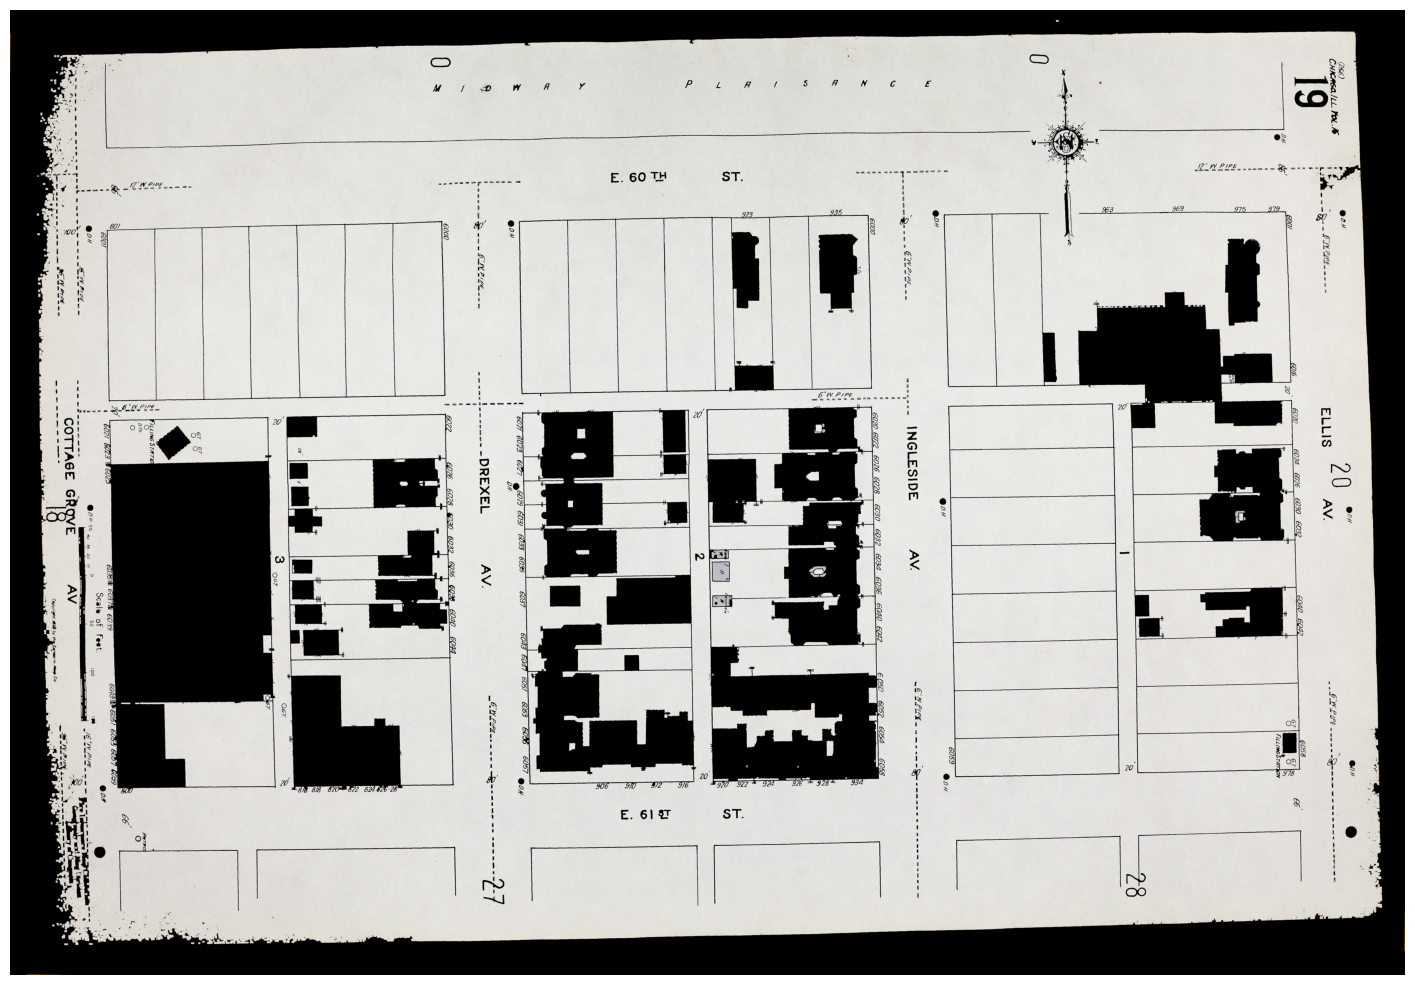

(4, 5706, 8248)


In [8]:
# Open the input GeoTIFF file
output_file = "Step_5/Step_5.tif"

# Define thresholds for white, gray, and beige pixels
white_threshold = 210
gray_threshold = 200
beige_threshold = 182

# Define the minimum area for regions to be preserved
min_region_area = 100

with rasterio.open(original_map) as src:
    # Read the image data
    img_data: np.ndarray = src.read()
    
    # Convert to 8-bit unsigned integer (assuming input is in some other format)
    img_data = img_data.astype('uint8')
    
    # Check the band count and shape
    num_bands, height, width = img_data.shape
    
    # Iterate through each pixel and check if it's white, gray, or beige
    white_pixels = (img_data[0] >= white_threshold) & (img_data[1] >= white_threshold) & (img_data[2] >= white_threshold)
    gray_pixels = ((img_data[0] >= gray_threshold) & (img_data[0] < white_threshold)) & \
                  ((img_data[1] >= gray_threshold) & (img_data[1] < white_threshold)) & \
                  ((img_data[2] >= gray_threshold) & (img_data[2] < white_threshold))
    beige_pixels = ((img_data[0] >= beige_threshold) & (img_data[0] < gray_threshold)) & \
                   ((img_data[1] >= beige_threshold) & (img_data[1] < gray_threshold)) & \
                   ((img_data[2] >= beige_threshold) & (img_data[2] < gray_threshold))
    
    # Create a binary mask indicating where pixels are not white, gray, or beige
    non_white_gray_beige_pixels = ~white_pixels & ~gray_pixels & ~beige_pixels
    
    # Perform binary erosion to remove small isolated black regions
    structuring_element = np.ones((5, 5), dtype=bool)  # Adjust structuring element size as needed
    eroded_mask = binary_erosion(non_white_gray_beige_pixels, structure=structuring_element)
    
    # Adjust the structuring element size dynamically based on num_closing_iterations
    num_closing_iterations = 5  # Example: Change this value to control intensity
    structuring_element_size = 2 * num_closing_iterations + 1  # Size increases with intensity
    structuring_element = np.ones((structuring_element_size, structuring_element_size), dtype=bool)
    
    # Perform binary closing with dynamic structuring element size
    closed_mask = binary_closing(eroded_mask, structure=structuring_element)
    
    # Create a new image with only white, gray, and beige pixels and preserved larger structures
    processed_img_data = img_data.copy()
    processed_img_data[:, closed_mask] = 0  # Set black pixels in the processed regions to 0
    
    # Ensure the image data has 3 bands
    if processed_img_data.shape[0] != 3:
        processed_img_data = processed_img_data[:3]  # Keep only the first 3 bands
    
    # Create a new GeoTIFF file for the output
    profile = src.profile
    profile.update(count=3, dtype='uint8')  # Update profile for 3 bands and uint8 dtype
    
    with rasterio.open(output_file, 'w', **profile) as dst:
        # Write the processed image data to the output file
        dst.write(processed_img_data)

# Open the output image using Matplotlib for preview
plt.figure(figsize=(18, 16))  # Adjust the width and height as needed
plt.imshow(processed_img_data.transpose(1, 2, 0))  # Transpose the image data for correct display
plt.axis('off')
plt.show()

print(img_data.shape)


Step 6

Clean image from previous step and set color to green (for easy overlaying later)

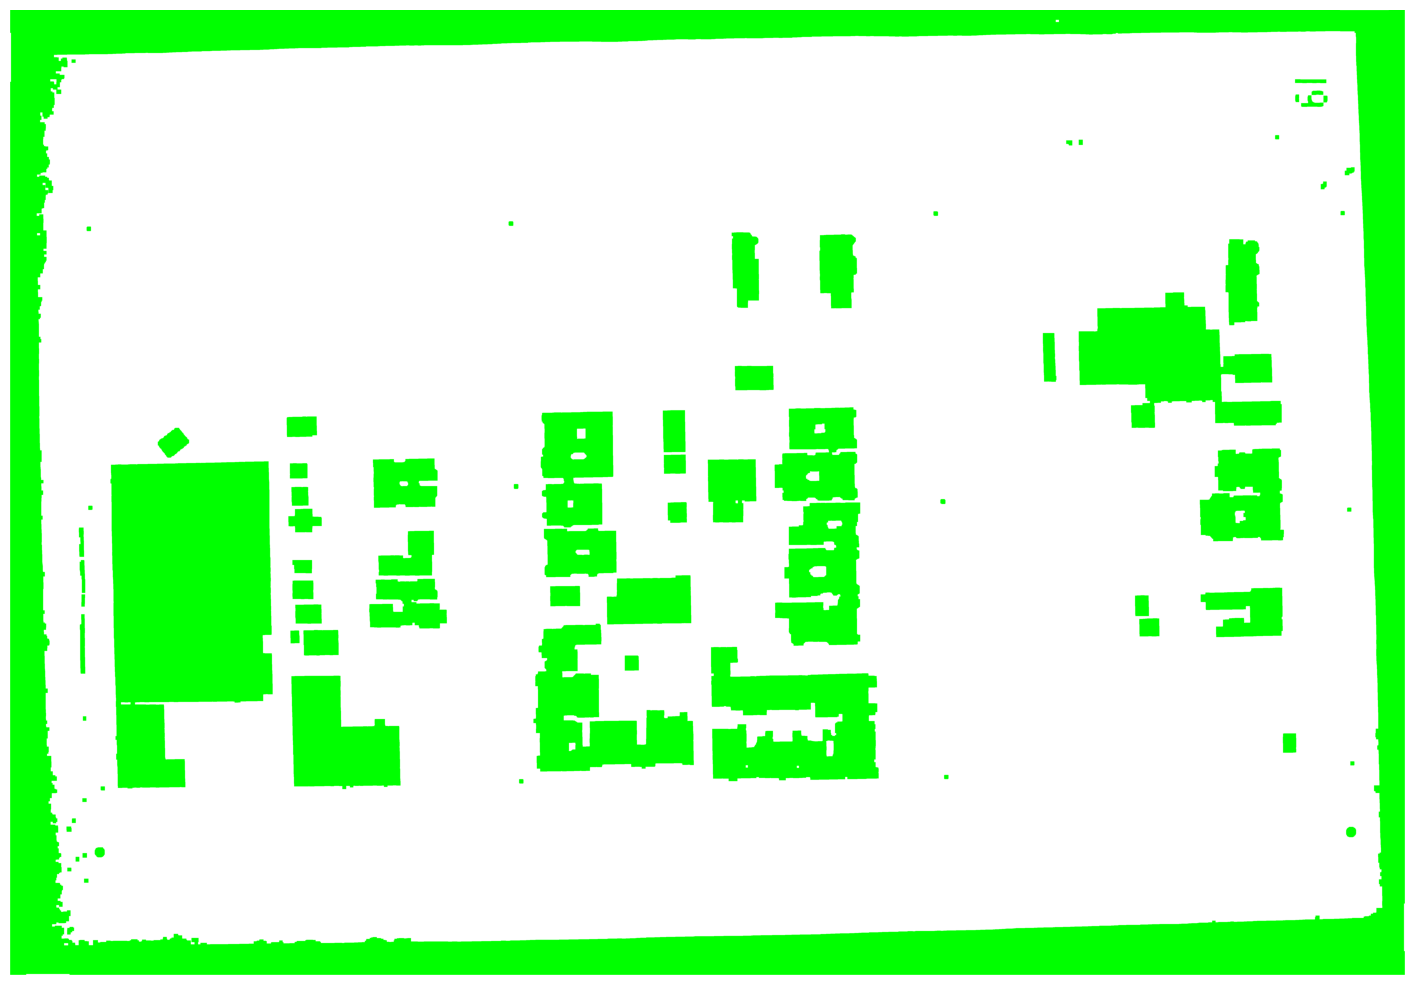

In [9]:
# Open the input GeoTIFF file
input_file = "Step_5/Step_5.tif"
output_file = "Step_6/Step_6.tif"

# Define thresholds for separating foreground from background
foreground_threshold = 25  # Adjust as needed

# Define the size of the structuring element for morphological operations
structuring_element_size = 3

# Define the size of the structuring element for thin lines removal
line_removal_element_size = 20  # Adjust this based on the thickness of the lines

with rasterio.open(input_file) as src:
    # Read the image data
    img_data = src.read()
    
    # Convert to 8-bit unsigned integer (assuming input is in some other format)
    img_data = img_data.astype('uint8')
    
    # Check the band count and shape
    num_bands, height, width = img_data.shape
    
    # Apply thresholding to separate foreground (building footprints and thin lines) from background
    foreground_mask = (img_data[0] <= foreground_threshold) & \
                      (img_data[1] <= foreground_threshold) & \
                      (img_data[2] <= foreground_threshold)
    
    # Perform binary erosion to remove thin lines and small isolated regions
    structuring_element = np.ones((structuring_element_size, structuring_element_size), dtype=bool)
    eroded_mask = binary_erosion(foreground_mask, structure=structuring_element)
    
    # Perform binary opening to remove thin lines
    line_removal_element = np.ones((line_removal_element_size, line_removal_element_size), dtype=bool)
    opened_mask = binary_opening(eroded_mask, structure=line_removal_element)
    
    # Label connected components (clusters of black pixels)
    labels, num_features = label(opened_mask)
    
    # Filter out small regions (parcel boundaries) while keeping the large regions (building footprints)
    filtered_mask = np.zeros_like(opened_mask, dtype=bool)
    for i in range(1, num_features + 1):
        if np.sum(labels == i) > 130:  # Adjust the minimum area threshold as needed
            filtered_mask |= labels == i
    
    # Create a new image with only building footprints and change black pixels to green
    building_footprints_img = img_data.copy()
    
    # Identify black pixels
    black_pixels = filtered_mask
    
    # Set black pixels to green (0, 255, 0)
    building_footprints_img[0, black_pixels] = 0    # Red channel
    building_footprints_img[1, black_pixels] = 255  # Green channel
    building_footprints_img[2, black_pixels] = 0    # Blue channel
    
    # Set non-building footprint pixels to white
    building_footprints_img[:, ~filtered_mask] = 255
    
    # Ensure the image data has 3 bands
    if building_footprints_img.shape[0] != 3:
        building_footprints_img = building_footprints_img[:3]  # Keep only the first 3 bands
    
    # Create a new GeoTIFF file for the output
    profile = src.profile  # Access the profile inside the `with` block
    profile.update(count=3, dtype='uint8')  # Update profile for 3 bands and uint8 dtype

    with rasterio.open(output_file, 'w', **profile) as dst:
        # Write the image data to the output file
        dst.write(building_footprints_img)

# Display the result
plt.figure(figsize=(18, 16))  # Adjust the width and height as needed
plt.imshow(building_footprints_img.transpose(1, 2, 0))  # Transpose the image data for correct display
plt.axis('off')
plt.show()

Step 7

Overlay result from Step 6 (dough) with result from Step 4 (stencil)

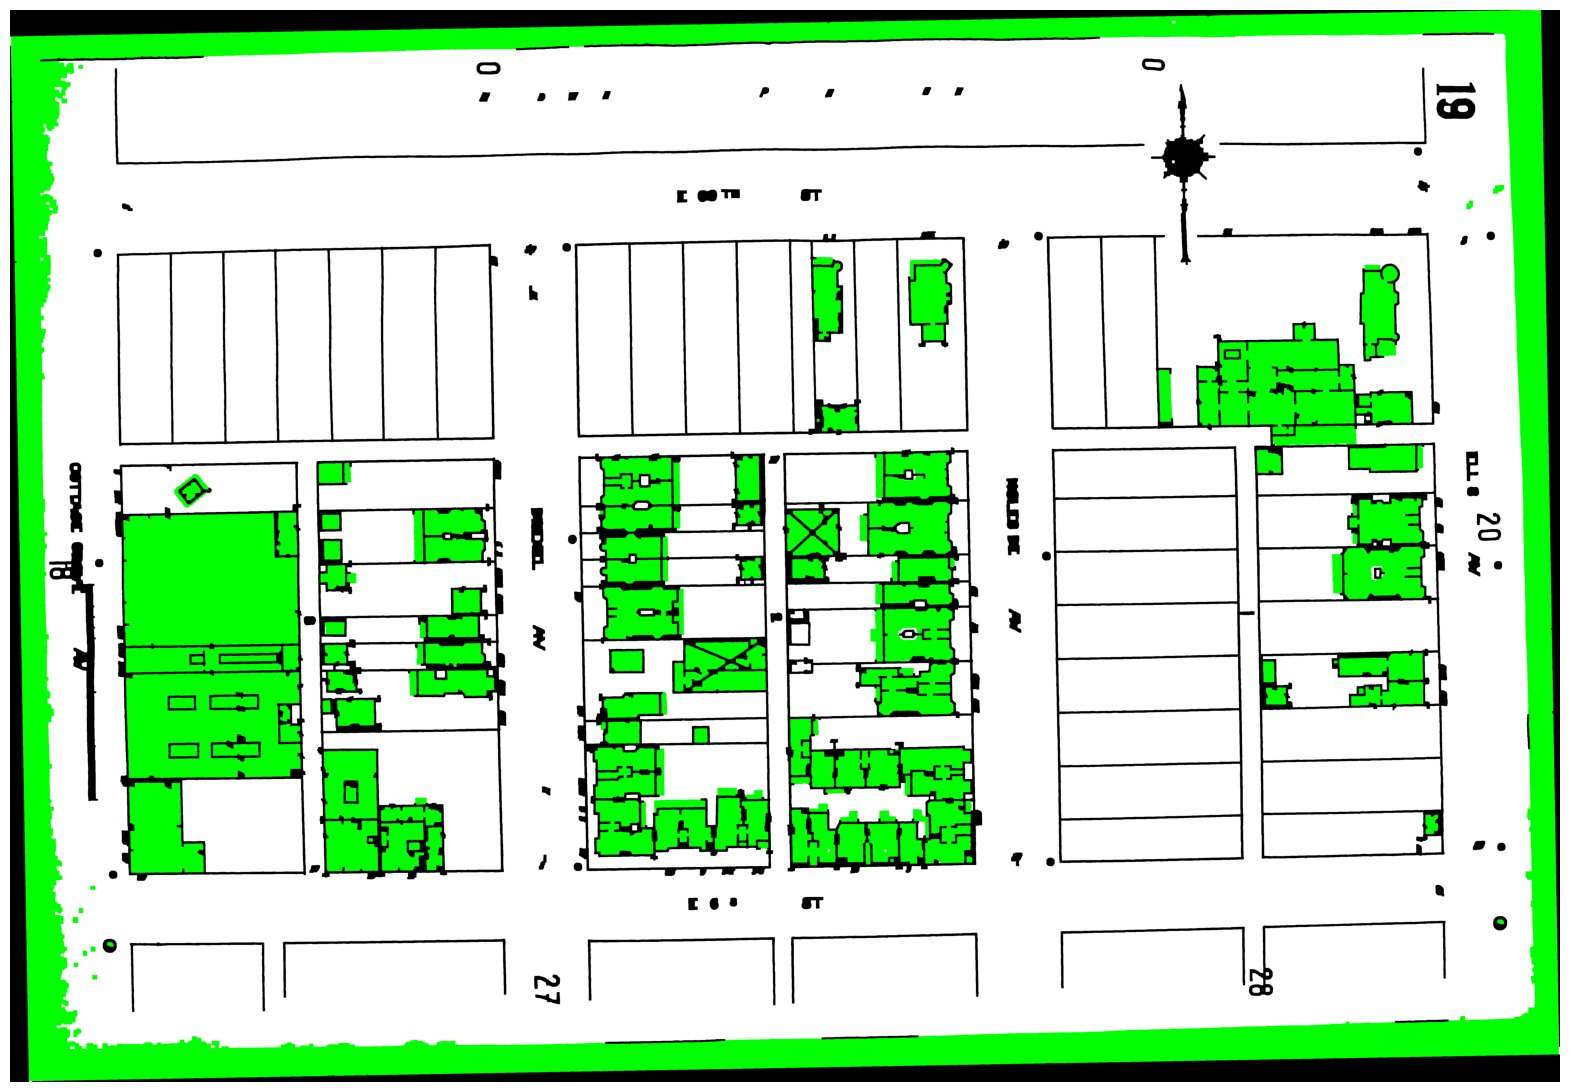

In [10]:
# File paths
mask_file = "Step_6/Step_6.tif"  # Mask file (green and white)
image_file = "Step_4/Step_4.tif"  # Target image (black and white)
output_file = "Step_7/Step_7.tif"  # Output image file

# Open the mask and the target image
with rasterio.open(mask_file) as mask_src, rasterio.open(image_file) as img_src:
    # Read the mask (RGB) and target image (grayscale)
    mask_data = mask_src.read()  # Mask file assumed to have 3 bands (RGB)
    img_data = img_src.read(1)  # Target image is single-band grayscale

    # Ensure the dimensions match
    if mask_data.shape[1:] != img_data.shape:
        raise ValueError("Mask and target image dimensions do not match!")

    # Identify black pixels in the target image
    black_mask = img_data == 0

    # Create a result image initialized with the mask data
    result_data = mask_data.copy()

    # Overlay black pixels from the target image onto the mask
    result_data[0][black_mask] = 0  # Set red channel to black
    result_data[1][black_mask] = 0  # Set green channel to black
    result_data[2][black_mask] = 0  # Set blue channel to black

    # Save the overlayed result
    profile = mask_src.profile
    profile.update(dtype='uint8', count=3, compress='lzw')  # Update profile for RGB output

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(result_data)  # Write the RGB data

# Display the resulting image
plt.figure(figsize=(20, 18))
plt.imshow(result_data.transpose(1, 2, 0))  # Transpose for correct display
plt.axis('off')
plt.show()

Step 8

Remove stencil

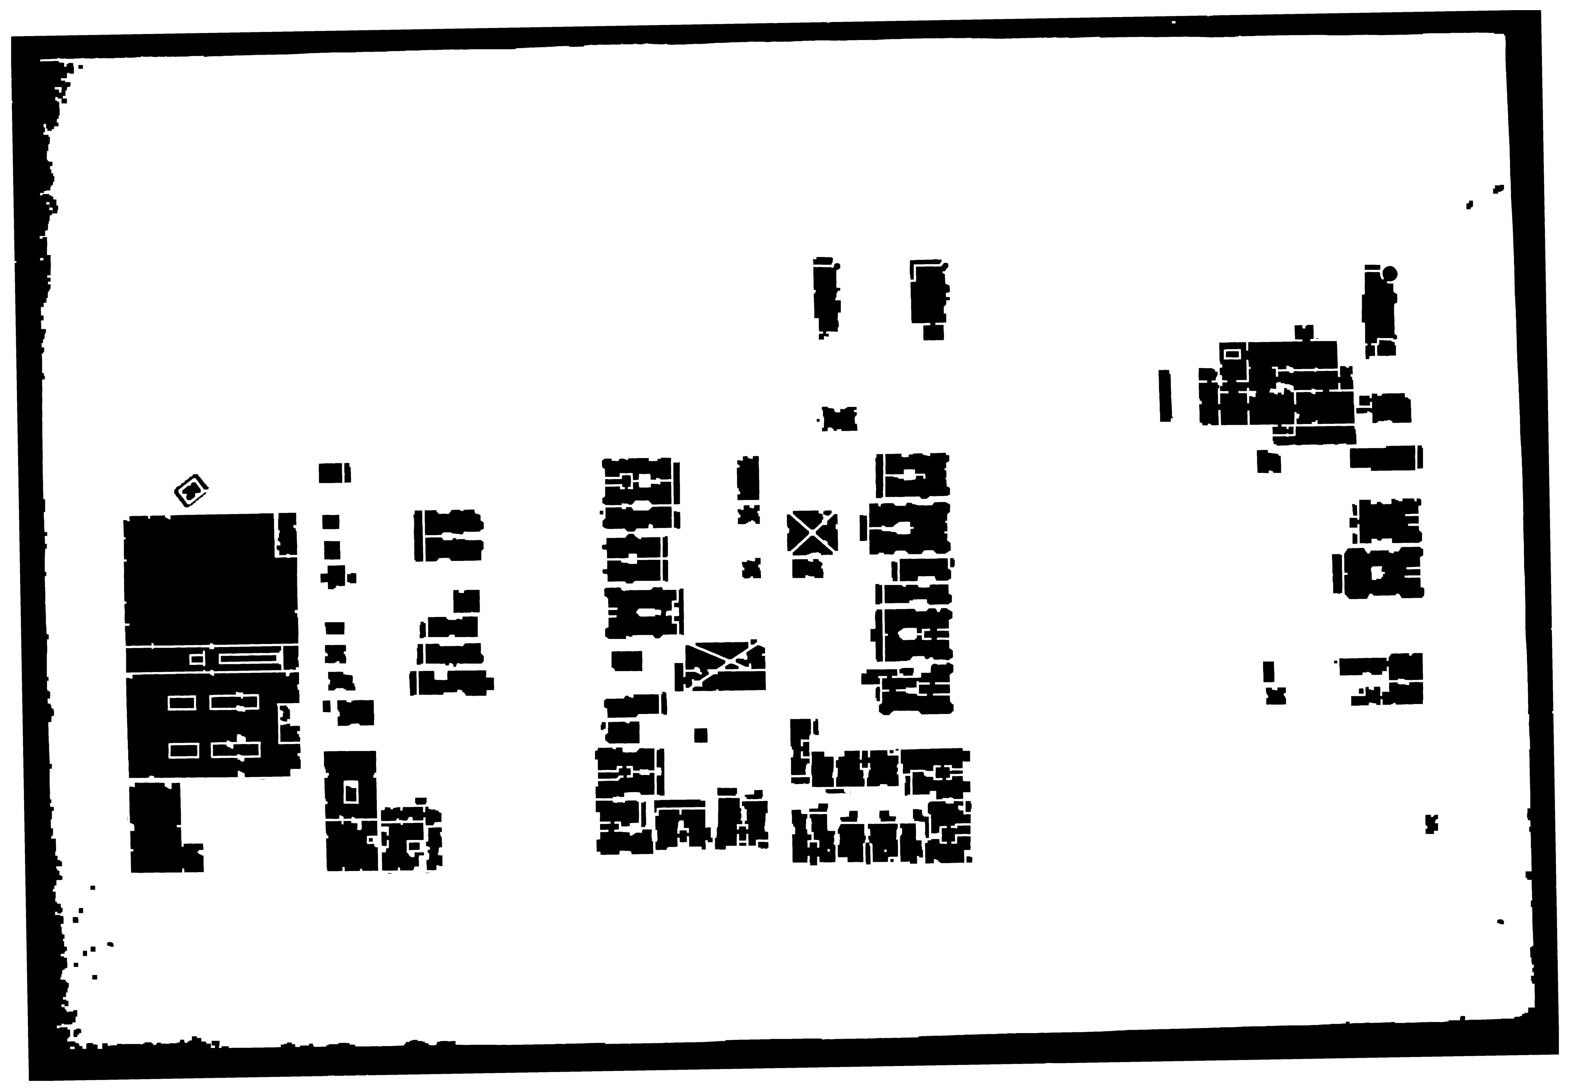

In [11]:
# File paths
stenciled_file = "Step_7/Step_7.tif"  # Input stencil file
output_file = "Step_8/Step_8.tif"         # Output binary file

# Open the stencil image
with rasterio.open(stenciled_file) as src:
    # Read the stencil image data
    stenciled_data = src.read()  # Assumed to be 3-band (RGB)

    # Create a binary result image (initialize as white)
    binary_data = np.ones_like(stenciled_data[0], dtype='uint8') * 255

    # Identify green pixels (R=0, G=255, B=0)
    green_mask = (stenciled_data[0] == 0) & (stenciled_data[1] == 255) & (stenciled_data[2] == 0)

    # Set green pixels to black in the binary image
    binary_data[green_mask] = 0

    # Save the binary image as a single-band GeoTIFF
    profile = src.profile
    profile.update(dtype='uint8', count=1, compress='lzw')  # Update profile for single-band output

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(binary_data, 1)  # Write to the first band

# Display the resulting image
plt.figure(figsize=(20, 18))
plt.imshow(binary_data, cmap='gray')  # Display the binary image
plt.axis('off')
plt.show()

Step 9

Filter image from Step 8 by a min_area_threshold.

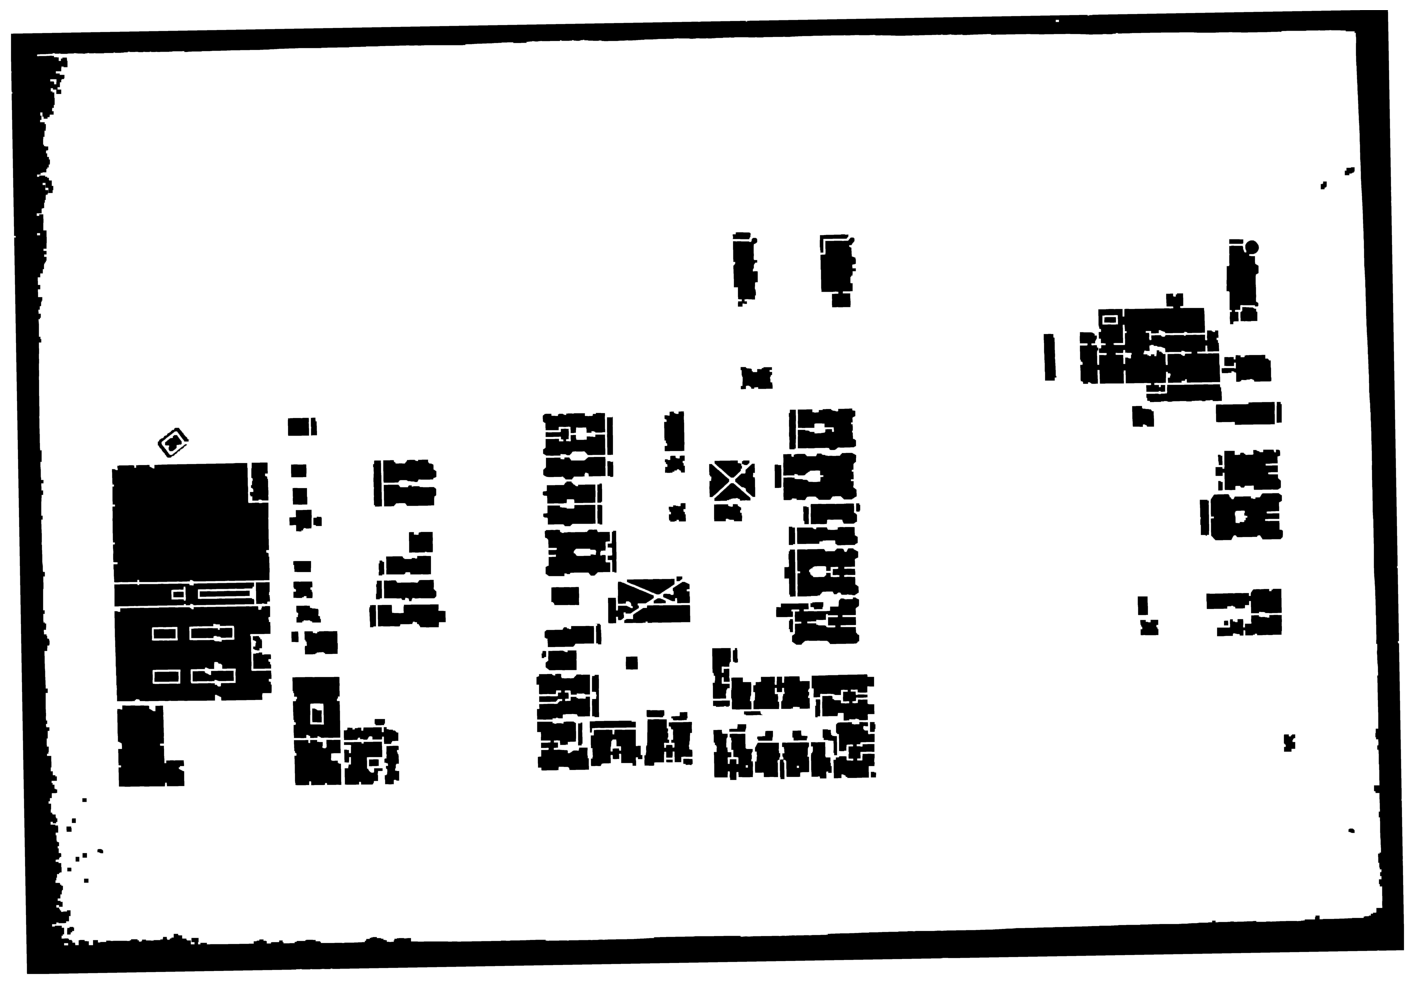

In [12]:
# Input and output file paths
input_file = "Step_8/Step_8.tif"  # Use dilated image from the first code as input
output_file = "Step_9/Step_9.tif"

# Threshold for foreground (black pixels)
foreground_threshold = 20

# Minimum area threshold for connected components (in pixels squared)
min_area_threshold = 500

# Open the input GeoTIFF file (dilated output)
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Threshold to create a foreground mask (black pixels)
    foreground_mask = img_data <= foreground_threshold  # 0=black, foreground

    # Label connected components (clusters of black pixels)
    labels, num_features = label(foreground_mask)  # Connected components labeling

    # Compute the size of each connected component (use bincount for efficiency)
    component_sizes = np.bincount(labels.ravel())  # Count sizes of each component
    component_sizes[0] = 0  # Ignore the background (label 0)

    # Filter out small components (use boolean indexing)
    valid_labels = np.where(component_sizes >= min_area_threshold)[0]  # Labels that meet size threshold

    # Create a mask for the valid components
    filtered_mask = np.isin(labels, valid_labels)  # True for valid components, False otherwise

    # Create a new image with the filtered mask
    filtered_img = np.full_like(img_data, 255, dtype='uint8')  # Initialize as white (255)
    filtered_img[filtered_mask] = img_data[filtered_mask]  # Keep the original black pixels in valid components

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(filtered_img, 1)  # Write to the first band

    # Display the processed image
    plt.figure(figsize=(18, 16))
    plt.imshow(filtered_img, cmap='gray')
    plt.axis('off')
    plt.show()

Step 10

Perform binary dilation to smooth out resulting footprints. (Provides cleaner results than closing)

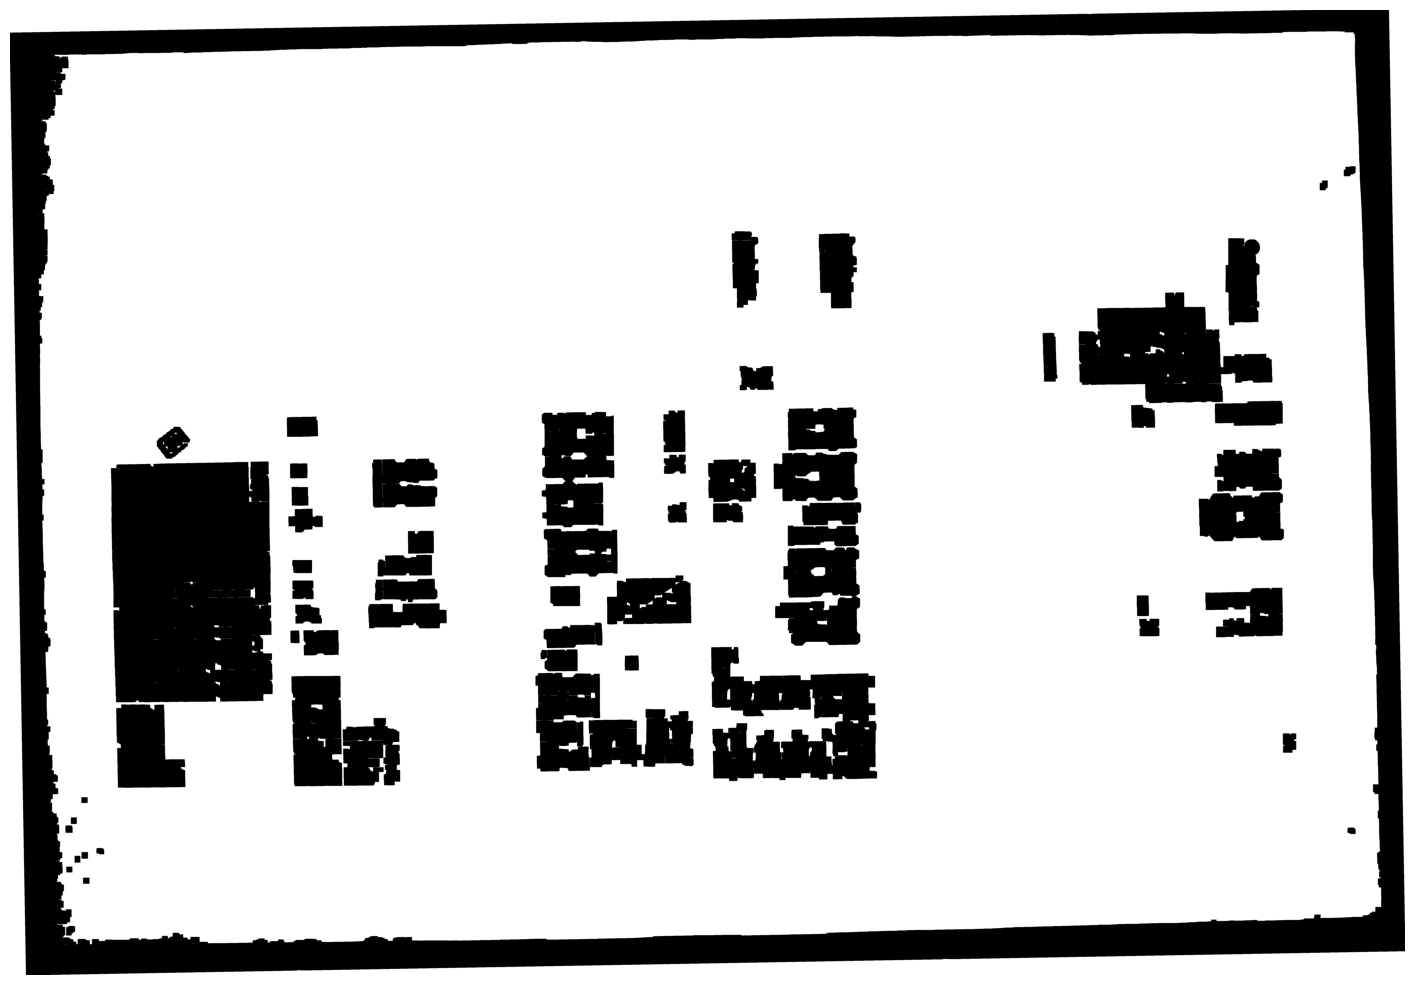

In [13]:
# Input and output file paths
input_file = "Step_9/Step_9.tif"
output_file = "Step_10/Step_10.tif"

# Thresholds for dashed lines (adjust these values as needed)
line_threshold = 35  # Pixel intensity threshold for dashed lines

# Structuring element sizes
dilation_size = 13  # Size for closing gaps in dashed lines

# Open the input GeoTIFF file
with rasterio.open(input_file) as src:
    # Read the image data as a single band
    img_data = src.read(1).astype('uint8')  # Ensure 8-bit unsigned integer

    # Step 1: Isolate dashed lines
    dashed_mask = img_data <= line_threshold  # True for dashed-line pixels

    # Step 2: Apply morphological closing to connect dashed lines
    structuring_element = np.ones((dilation_size, dilation_size), dtype=bool)
    solid_lines_mask = binary_dilation(dashed_mask, structure=structuring_element)

    # Step 3: Combine with original image
    result_img = img_data.copy()  # Copy original image
    result_img[solid_lines_mask] = 0  # Set connected lines to black (or desired color)

    # Write the output to a new GeoTIFF
    profile = src.profile
    profile.update(count=1, dtype='uint8')

    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(result_img, 1)  # Write to the first band

    # Display the original and processed images
    plt.figure(figsize=(18,16))
    plt.imshow(result_img, cmap='gray')
    plt.axis('off')

    plt.show()